In [1]:
%matplotlib widget
import os
import argparse
import matplotlib
import numpy as np

from plantcv import plantcv as pcv
pcv.__version__

'3.14.2'

In [4]:
class options:
    def __init__(self):        
        self.image = "imgs/10.9.1.29_pos-153-001-003_2019-10-26-19-05.jpg" 
        self.debug = "plot"
        self.writeimg = False
        self.result = "data_output"
        self.outdir = "img_output"
args = options()
pcv.params.debug_outdir = args.outdir
pcv.params.debug = args.debug

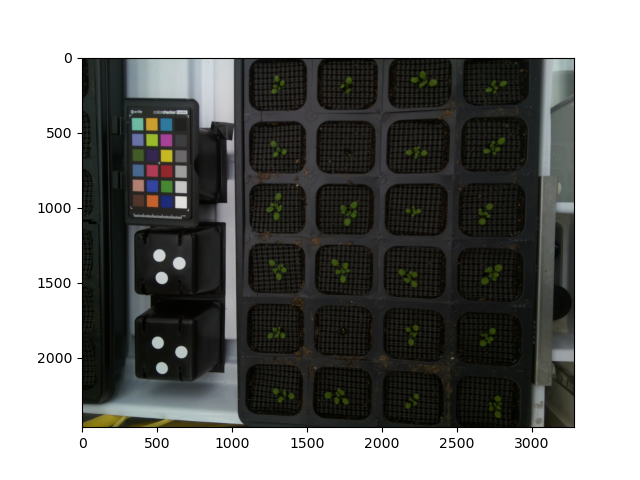

In [5]:
img, path, filename = pcv.readimage(filename=args.image)


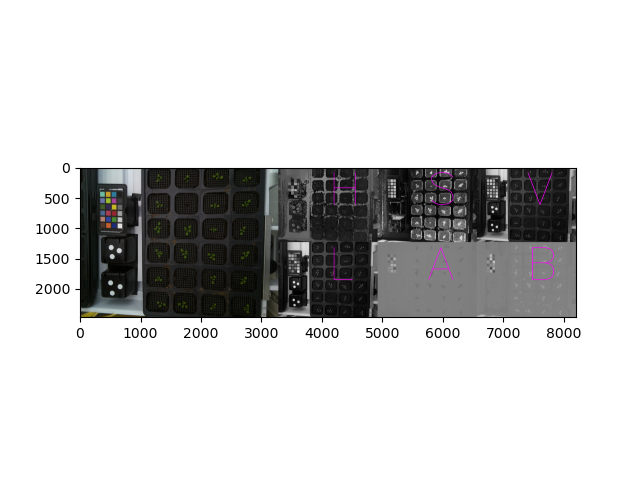

In [6]:
# Update params related to plotting so we can see better 
pcv.params.text_size = 50
pcv.params.text_thickness = 20

colorspace_img = pcv.visualize.colorspaces(rgb_img=img)


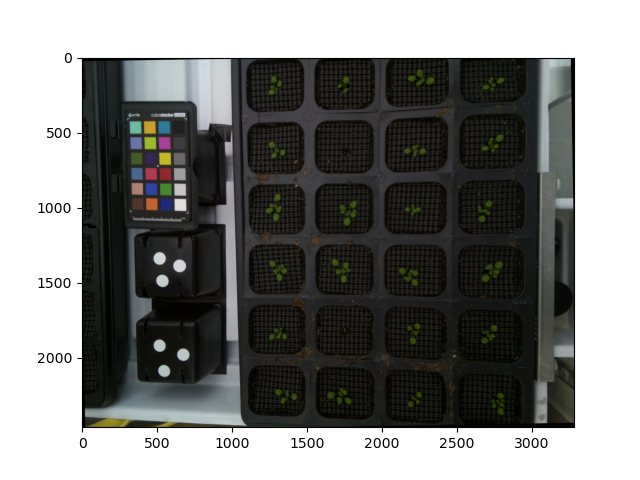

In [7]:
rot_img = pcv.transform.rotate(img=img, rotation_deg=1, crop=True)

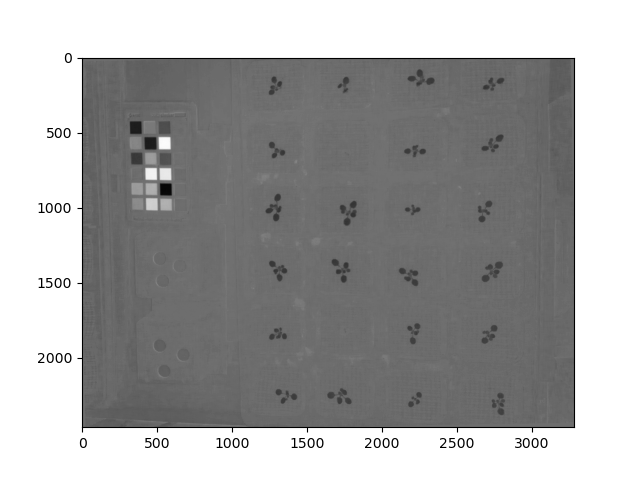

In [8]:
#### Create a mask and begin to clean it ####
# Change color space for plant extraction
a = pcv.rgb2gray_lab(rgb_img=rot_img, channel="a")


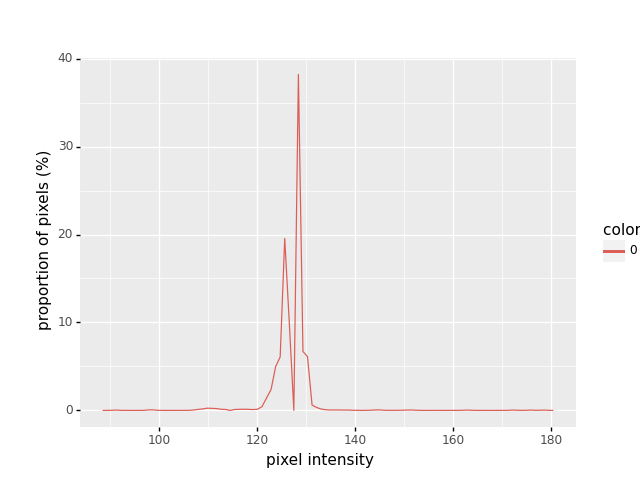

In [9]:
hist = pcv.visualize.histogram(img=a, bins=100)

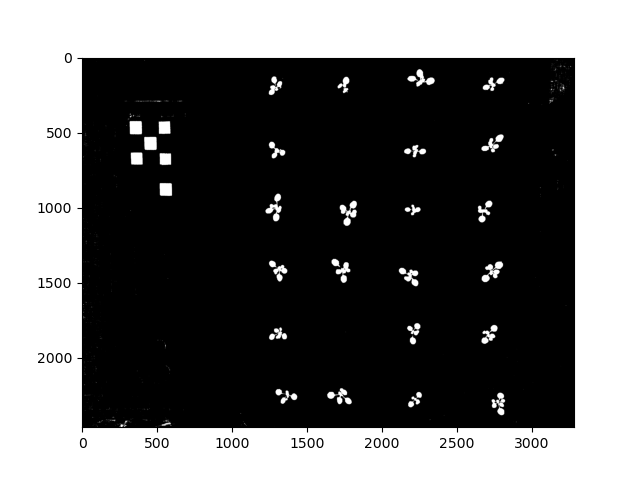

In [10]:
# Threshold
a_thresh = pcv.threshold.binary(gray_img=a, threshold=120, max_value=255, object_type='dark')


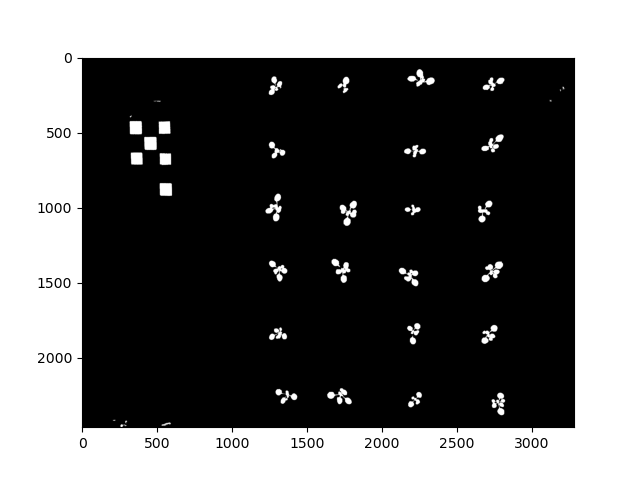

In [11]:
# Fill in small objects 
a_fill_image = pcv.fill(bin_img=a_thresh, size=50)


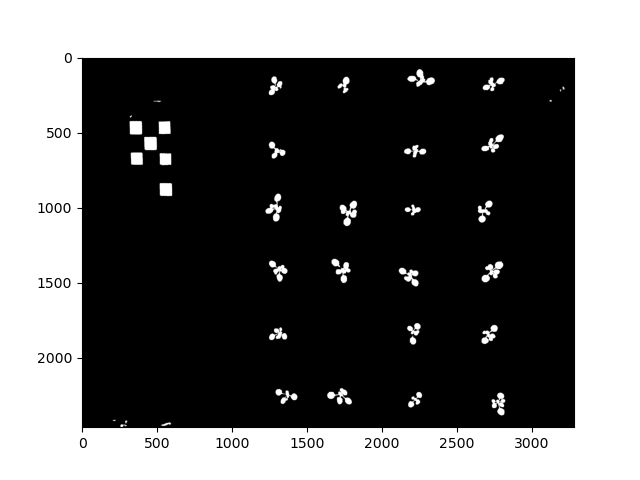

In [12]:
# Dilate 
a_dilated = pcv.dilate(gray_img=a_fill_image, ksize=2, i=1)

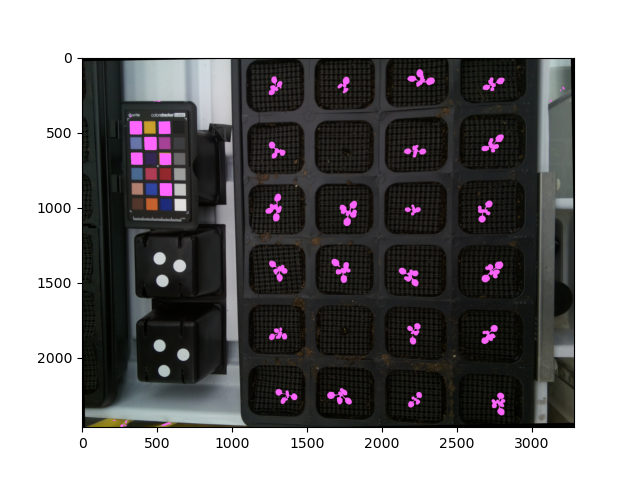

In [13]:
obj, obj_hierarchy = pcv.find_objects(img=rot_img, mask=a_dilated)

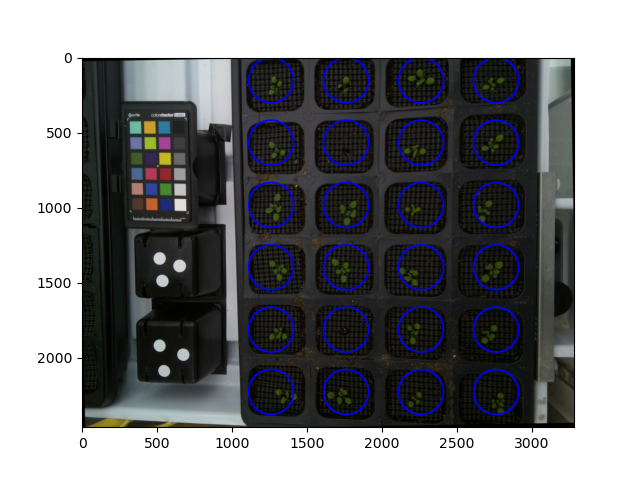

In [14]:
# Create a grid of ROIs 
pcv.params.line_thickness = 10
rois1, roi_hierarchy1 = pcv.roi.multi(img=rot_img, coord=(1260, 155), radius=150, 
                                      spacing=(500, 415), nrows=6, ncols=4)

In [15]:
plant_id = range(0,len(rois1))

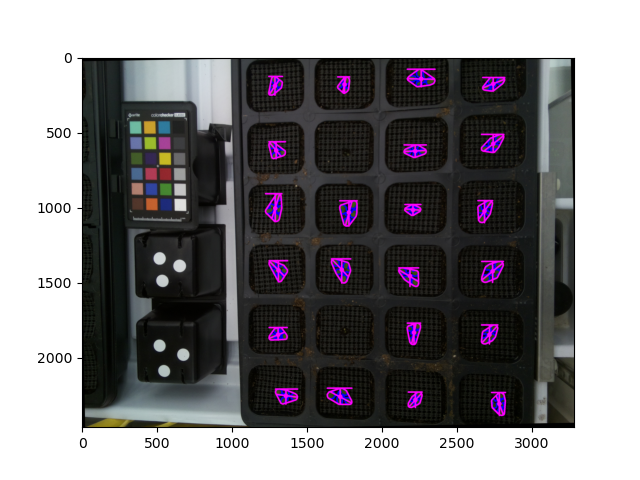

In [16]:
img_copy = np.copy(rot_img)
pcv.params.debug = None
for i in range(0, len(rois1)):
    roi = rois1[i]
    hierarchy = roi_hierarchy1[i]
    id_label = plant_id[i]
    # Find objects
    filtered_contours, filtered_hierarchy, filtered_mask, filtered_area = pcv.roi_objects(
        img=rot_img, roi_type="partial", roi_contour=roi, roi_hierarchy=hierarchy, object_contour=obj, 
        obj_hierarchy=obj_hierarchy)

    if filtered_area > 0:
        # Combine objects together in each plant     
        plant_contour, plant_mask = pcv.object_composition(img=rot_img, contours=filtered_contours, hierarchy=filtered_hierarchy)        
        # Analyze the shape of each plant 
        img_copy = pcv.analyze_object(img=img_copy, obj=plant_contour, mask=plant_mask, label=id_label)

pcv.plot_image(img_copy)
pcv.print_image(img_copy, os.path.join(args.outdir, filename + "_shapes.jpg"))



In [17]:
# pcv.print_results(filename=args.result)
pcv.outputs.save_results(filename=args.result)